## **プログラム全体の流れ**
- データローダの作成
- ネットワークの定義
- 誤差関数の定義
- 学習ループの設計
- モデルの学習
- モデルの評価

# k-fold cross validationの仕組みを作っておく

- negative(165), positive(55)が混ざるようにしたい\
→別々で分割して，結合する
- 時期も混ざるようにしたい\
→症例でシャッフルしてから分割する

In [1]:
import glob
from sklearn.model_selection import KFold

In [2]:
# 症例リストを取り出す
neg = glob.glob("dataset/PAS_imgs/negative/*")
pos = glob.glob("dataset/PAS_imgs/positive/*")

In [3]:
def make_kfold_set(k):
    k = k

    kf = KFold(n_splits=k, shuffle=True)

    neg_train_test_list = []
    pos_train_test_list = []
    
    neg = glob.glob("dataset/PAS_imgs/negative/*")
    pos = glob.glob("dataset/PAS_imgs/positive/*")

    for train_index, test_index in kf.split(neg):
        kth_train = []
        kth_test = []
        for i in train_index:
            kth_train.append(neg[i])
        for i in test_index:
            kth_test.append(neg[i])
        neg_train_test_list.append((kth_train, kth_test))

    for train_index, test_index in kf.split(pos):
        kth_train = []
        kth_test = []
        for i in train_index:
            kth_train.append(pos[i])
        for i in test_index:
            kth_test.append(pos[i])
        pos_train_test_list.append((kth_train, kth_test))


    posneg_train_test_list = []

    for i in range(k):
        train = pos_train_test_list[i][0] + neg_train_test_list[i][0]
        test = pos_train_test_list[i][1] + neg_train_test_list[i][1]
        posneg_train_test_list.append((train, test))

    
    return posneg_train_test_list

<div style="text-align: center;">
<IMG SRC="https://drive.google.com/uc?id=1rWgWkMT0LLv17p21C2NQMjPh_bkJ_Fcu" width="70%"> 
<br>
図5　ミニバッチ学習のおさらい
</div>

-------------------fold 1 --------------------
epoch1
train_loss:tensor(0.2716, device='cuda:0') train_acc:tensor(0.9235, device='cuda:0')
val_loss:tensor(1.4853, device='cuda:0') val_acc:tensor(0.7714, device='cuda:0')
epoch2
train_loss:tensor(0.5108, device='cuda:0') train_acc:tensor(0.8309, device='cuda:0')
val_loss:tensor(1.5498, device='cuda:0') val_acc:tensor(0.7714, device='cuda:0')
epoch3
train_loss:tensor(0.6294, device='cuda:0') train_acc:tensor(0.7382, device='cuda:0')
val_loss:tensor(1.0998, device='cuda:0') val_acc:tensor(0.7714, device='cuda:0')
-------------------fold 2 --------------------
epoch1
train_loss:tensor(0.2560, device='cuda:0') train_acc:tensor(0.9244, device='cuda:0')
val_loss:tensor(1.5947, device='cuda:0') val_acc:tensor(0.7500, device='cuda:0')
epoch2
train_loss:tensor(0.4427, device='cuda:0') train_acc:tensor(0.8741, device='cuda:0')
val_loss:tensor(1.4501, device='cuda:0') val_acc:tensor(0.7500, device='cuda:0')
epoch3
train_loss:tensor(0.5107, device='

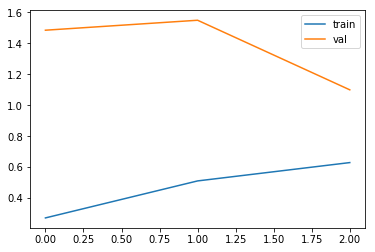

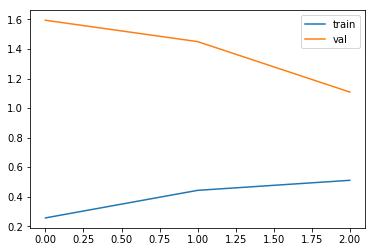

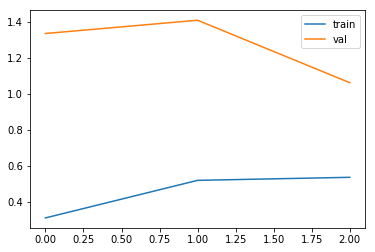

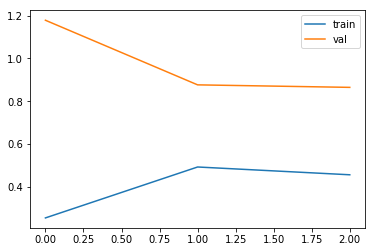

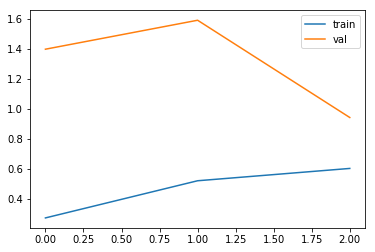

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import pydicom
import matplotlib.pyplot as plt
from PIL import Image

import cv2

k = 5
k_train_test_set = make_kfold_set(k)

# データセットクラスを作る
class PASDataset(Dataset):
    # trainとtestが分割されているリストを受け取る
    def __init__(self, train_test, mode):
        super().__init__()
        # 呼び出された瞬間に起こってほしいこと（コンストラクタ）
        if mode == "train":
            self.patients = train_test[0]
        elif mode == "test":
            self.patients = train_test[1]
        else:
            raise Exception('Error!')
        self.imgs = self.patient2imgs(self.patients)
        
    def __len__(self):
        # データがいくつあるのかを数える
        return len(self.imgs)
    
    
    def __getitem__(self, index):
        # データが取り出される瞬間にどのような形であってほしいかを定義する
        
        image_path = self.imgs[index]
        img = pydicom.read_file(image_path)
        img = np.int32(img.pixel_array)
        img = Image.fromarray(img).resize((256, 256))
        img = np.array(img)
        img = np.expand_dims(img, 0) # 1チャンネルであることを明示する
        img = torch.tensor(img) # 行列をpytorchで扱える形式（tensor型）に変換する
        img = img / 2048.0
        
        mask_path = image_path.replace("raw", "label").replace("dcm", "png")
        mask = np.array(Image.open(mask_path).resize((256, 256)))
        img[0] = self.mask_imgs(img[0], mask)
        
        # 胎盤の重心を中心とした大きめの正方形で切り取る
        img = self.crop_img(img, mask)
        
        # 水増し
        img = self.transforms(img)
        
        if "positive" in image_path:
            label = 1
        else:
            label = 0
        return img, label, image_path
    
    def patient2imgs(self, patient_list):
        imgs_list = []
        for patient in patient_list:
            img_paths = glob.glob(patient + "/raw/*")
            for img in img_paths:
                if "dcm" in img:
                    imgs_list.append(img)
        return imgs_list
    
    def mask_imgs(self, img, mask):
        masked_img = img
        zeros = mask == 0
        masked_img[zeros] = 0
        return masked_img
    
    def crop_img(self, img, mask):
        # maskから重心を計算
        nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(mask)
        # 重心を中心に，imgを切り取り
        
        return cropped_img

#transforms = transfomrs.Compose([
    
#])     

pas_train = PASDataset(k_train_test_set[0], "train", transform=)
pas_test = PASDataset(k_train_test_set[0], "test", transform=)
train_loader = DataLoader(pas_train, batch_size=5)
test_loader = DataLoader(pas_test, batch_size=5)




epochs = 3 #ミニバッチのサンプリングが一巡 = 1 epoch
loss_min = 100000 # validation_lossが小さくなった場合にのみモデルを保存しておくためのメモ

# k回の繰り返し
for fold in range(k):
    print("-------------------fold " + str(fold+1) + " --------------------")
    # データローダの作成
    pas_train = PASDataset(k_train_test_set[fold], "train")
    pas_test = PASDataset(k_train_test_set[fold], "test")
    train_loader = DataLoader(pas_train, batch_size=5)
    test_loader = DataLoader(pas_test, batch_size=5)
    
    # モデルの定義
    model = models.resnet50(pretrained=False)
    model.load_state_dict(torch.load("resnet50-19c8e357.pth"), strict=False)

    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.fc = nn.Linear(2048, 2, bias=True)

    # CPUを使う場合は，下記を削除する
    model = model.to("cuda")
    # optimizer（勾配降下法のアルゴリズム）の準備
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 誤差関数の定義
    criterion = CrossEntropyLoss()

    # 学習ループ
    train_loss_list = [] # epoch毎のtrain_lossを保存しておくための入れ物
    val_loss_list = [] # epoch毎のvalidation_lossを保存しておくための入れ物

    # ここからループ開始
    for epoch in range(epochs):

        train_loss_add = 0 # 1エポック分の誤差を累積しておくための変数
        train_acc_add = 0

        model.train() #学習モードであることを明示

        for i, data in enumerate(train_loader):

            x, t, path = data # ①データの読み込み
            # CPU環境で動かす際は，下記2行を削除する
            x = x.float().to("cuda")
            t = t.to("cuda")
            predict = model(x) # ②順伝播計算

            loss = criterion(predict, t) # ③誤差の計算
            _, preds = torch.max(predict, 1)
            #print(preds)

            model.zero_grad()# 誤差逆伝播法のための準備
            loss.backward() # ④誤差逆伝播法による誤差の計算

            optimizer.step() # ⑤勾配を用いてパラメータを更新

            train_loss_add += loss.data * train_loader.batch_size # あとで平均を計算するために，誤差を累積しておく
            train_acc_add += torch.sum(preds == t.data)

        train_loss_mean = train_loss_add / len(pas_train) # 1epochでの誤差の平均を計算
        train_acc_mean = train_acc_add / float(len(pas_train))

        print("epoch" + str(epoch+1))
        print("train_loss:" + str(train_loss_mean), "train_acc:" + str(train_acc_mean))
        train_loss_list.append(train_loss_mean.cpu())# 1epoch毎の平均を格納しておく

        # validation
        model.eval() # 評価モード（学習を行わない）であることを明示

        val_loss_add = 0
        val_acc_add = 0
        for i, data in enumerate(test_loader):

            x, t, path = data

            # CPU環境で動かす際は，下記2行を削除する
            x = x.float().to("cuda")
            t = t.to("cuda")

            predict = model(x) # 順伝播計算

            _, preds = torch.max(predict, 1)

            loss = criterion(predict, t) # 誤差の計算
            val_loss_add += loss.data * test_loader.batch_size
            val_acc_add += torch.sum(preds == t.data)

        val_loss_mean = val_loss_add / len(pas_test)
        val_acc_mean = val_acc_add / float(len(pas_test))

        print("val_loss:" + str(val_loss_mean), "val_acc:" + str(val_acc_mean))
        val_loss_list.append(val_loss_mean.cpu())

        #if val_loss_mean < loss_min: # 前に保存したモデルよりもvalidation lossが小さければ，モデルを保存する
        #    torch.save(model.state_dict(), "models/fold" + str(fold + 1) + "_best.model")
        #    print("saved best model!")
        #    loss_min = val_loss_mean # 今回保存したモデルのvalidation lossをメモしておく
    
    # 各foldで，学習曲線を描画
    # 各foldで，testにおけるpredsとlabelをcsvに保存（全epochが終わった時点）
    plt.figure()
    plt.plot(train_loss_list, label="train")
    plt.plot(val_loss_list, label="val")
    plt.legend()
    plt.savefig("result/epoch_" + str(fold + 1) + ".png")

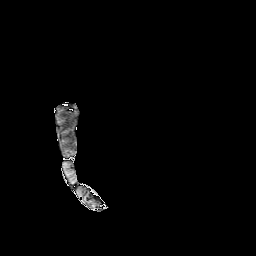

In [13]:
Image.fromarray(np.uint8(x[0][0].cpu() * 2048))

In [ ]:
k = 5
kfold_list = make_kfold_set(k)

for i in range(5):
    PAS = PASDataset(ith_fold)
    predict = model(PAS)

In [28]:
dcm = pydicom.read_file("dataset/PAS_imgs/positive/1029/raw/0.dcm")

In [29]:
len(pas_train)

676

In [87]:
model.conv1 = nn.Conv2d(1, 64, 7, 2, 3)

In [22]:
_, preds = torch.max(predict, 1)


In [24]:
preds

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [30]:
test_loader.batch_size

5

In [15]:
img_path = "dataset/PAS_imgs/positive/1029/raw/0.jpg"

In [16]:
mask_path = img_path.replace("raw", "label").replace("jpg", "png")

In [17]:
from PIL import Image
img = np.array(Image.open(img_path))
mask = np.array(Image.open(mask_path))

In [28]:
zeros = mask == 0

In [30]:
img[zeros] = 0 

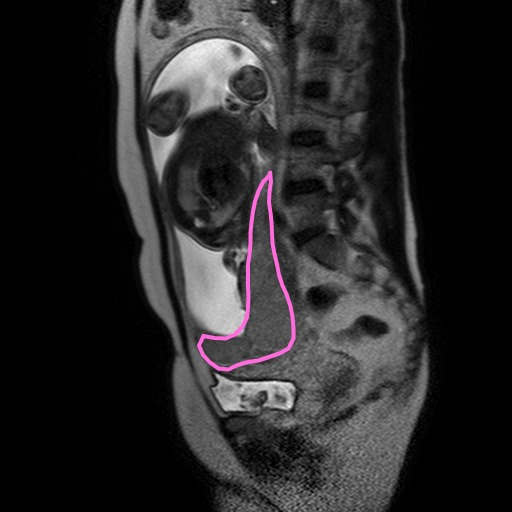

In [22]:
Image.open(img_path)

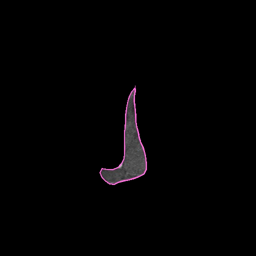

In [37]:
Image.fromarray(img).resize((256, 256))

In [12]:
nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(mask)

NameError: name 'cv2' is not defined

In [22]:
mask = np.array(Image.open(mask_path))
nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(mask)

In [21]:
import cv2

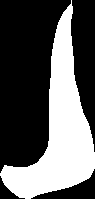

In [30]:
Image.open(mask_path).crop((199, 171, 199+95, 171+199))

In [45]:
data

array([[     0,      0,    512,    512, 255234],
       [   199,    171,     95,    199,   6910]], dtype=int32)

In [38]:
data[:,4]

array([255234,   6910], dtype=int32)

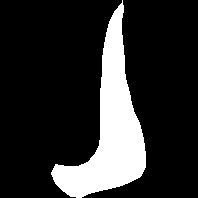

In [52]:
max_index = np.argmin(data[:,4])
object_width = data[max_index][2]
object_height = data[max_index][3]
object_center = (data[max_index][0]+(object_width/2), data[max_index][1]+(object_height/2))
hen = int(max(object_width, object_height)/2)
Image.open(mask_path).crop((object_center[0]-hen, object_center[1]-hen, object_center[0]+hen, object_center[1]+hen))

In [49]:
max(1,2)

2